# Хакатон Яндекс Маркет

## Задача проекта

Необходимо придумать способ подсказывать пользователю информацию о выборе упаковочного материала, а также разработать интерфейс для упаковщика.

Информация о компании
1.	Отрасль и направления деятельности: Маркетплейс, сервис для покупки товаров.
2.	Общее описание задачи: Для того, чтобы пользователь получил заказ, необходимо упаковать заказанные товары в посылки конечному клиенту. Компания заметила, что сотрудник тратит большое количество времени для выбора упаковочного материала в который необходимо упаковать товары. Существует большое количество упаковочного материала (коробочки, пакетики). Необходимо придумать способ подсказывать пользователю информацию о выборе упаковочного материала.
Интерфейс упаковщика должен отображать содержимое заказа для контроля комплектности. Интерфейс упаковщика должен на основании содержимого заказа, подсказывать упаковщику в какую тару (коробку, пакет, с учетом размера) нужно упаковать заказ. При определении варианта упаковки (тары) для заказа нужно учитывать тип товара, весогабаритные характеристики и необходимость в дополнительной упаковке для хрупких товаров.
3.	Цели сервиса:
*	С высокой точностью рекомендовать правильную упаковку для заказа,которая позволит доставить товары без порчи клиенту и минимизирует затраты на упаковочный материал,
*	Отображение статистики о работе модели,
*	Интерфейс о том, как советовать информацию по выбору коробкипользователю.

**Алгоритм подбора упаковки**

По итогу проектирования ML-продукта специалисты Data Science сформируют Docker Container: web сервис, в котором реализовано два обработчика событий (”ручки” / handler):

- **/health** - GET запрос без входных параметров. Ответ: {”status”: “ok”}
- **/pack** -  GET запрос, который принимает параметры заказа и возвращает рекомендованную упаковку.

**Параметры**

**Данные на вход:**

```
data = {"orderId": "unique_order_id",
 "items": [
    {"sku": "unique_sku_1", "count": 1, "size1": "5.1", "size2": "2.2", "size3": "5.3", "weight": "7.34", "type": ["2"]},
    {"sku": "unique_sku_2", "count": 3, "size1": "4", "size2": "5.23", "size3": "6.2", "weight": "7.45", "type": ["8", "9", "10"]},
    {"sku": "unique_sku_3", "count": 2, "size1": "11", "size2": "12.5", "size3": "13.3", "weight": "14.2", "type": ["15", "16"]}
   ]
}
```

**Успешный ответ**

```
{"orderid": "sdfsdf", "package": "ADC", "status": "ok"}
```

**Внутренняя ошибка сервиса**

```
{"orderid": "sdfsdf", "status": "fail"}
```

## Описание данных

**1. Заказы (data.csv)**

Информация по заказам и товарам (sku), которые в них содержатся

- whs - код сортировочного центра;
- orderkey - id заказа;
- selected_cartontype - код упаковки, которая была выбрана пользователем;
- box_num - количество коробок;
- recommended_cartontype - код упаковки, рекомендованной алгоритмом;
- selected_carton - код упаковки, которая была выбрана пользователем (дубль);
- sel_calc_cube - объём выбранной упаковки;
- recommended_carton - код упаковки, рекомендованной алгоритмом (дубль);
- pack_volume - рассчитанный объём упакованных товаров;
- rec_calc_cube - объем упаковки, рекомендованной алгоритмом;
- goods_wght - вес товара;
- sku - id товара;
- who - упаковщик;
- trackingid - id доставки;

**2. SKU (sku.csv)**

Выгрузка id товаров и их размеров.

- sku - id товара
- a, b, c, - размеры

**3. Карготипы товаров (sku_cargotypes.csv)**

Выгрузка id товаров и их карготипов.

- sku - id товара
- cargotype - карготип товара

**4. Описание карготипов (cargotype_info.csv)**

Таблица с идентификаторами карготипов и их описаниями

- cargotype - карготип
- description - описание

**5. Характеристики упаковок (carton.csv)**

Таблица с идентификаторами и линейными размерами упаковок.

- CARTONTYPE - идентификатор (код) упаковки;
- LENGTH, WIDTH, HEIGTH - линейные размеры упаковки;
- DISPLAYFRACK - коробка есть на складе (не учитывать для наших целей).

**6. Стоимость упаковок (carton_price.xlsx)**

Таблица с идентификаторами упаковок и их стоимостью.

- идентификатор (код) упаковки
- стоимость

## План действий - декомпозиция задачи

1. Загрузить данные и подготовить их к анализу:
  * Исследовать пропущенные значения;
  * Исследовать соответствие типов;
  * Исследовать дубликаты;
  * Проверить корректность наименований колонок;
  * Переименовать колонки;
  * Удалить дубликаты;
  * Привести типы;
  * Заменить пропущенные значения.
  * Добавить рассчетные данные.
2. Провести исследовательский анализ данных.
3. Подготовить данные для модели ML.
4. Обучить модели.
5. Оценить модели на кросс-валидации.
6. Провести анализ бизнесовой метрики.
7. Написать функцию для ML Ops model.py
8. Сформировать докер

## Загрузка данных и вывод данных

In [1]:
# Импортируем библиотеки:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
from scipy import stats as st
import pickle

# Закрепим формат float:
pd.set_option('display.float_format', '{:,.2f}'.format)

# Уберем предупреждения:
import warnings
warnings.simplefilter('ignore')

In [2]:
# Скачем датасеты с google drive:
!gdown 1HJWxQ9PhBTkrbXfaec9_Y9yb8S55g0Uc
!gdown 1ZO-ExOfiqtPvdPrvL_PiPTVS6xMmxb8V
!gdown 1IVAQFqiG3fgrBdESxAdq8Ka9DFuz71T9
!gdown 1a-d33-1H2iSbXVZsGLOMuQD61nxQ8sSp
!gdown 15fmCORJ0mwJzzUmOHJMCrpj1tDSLrheC
!gdown 1j8UYyJJi-0ukVW-8bMyhdYsxbFAWLtq5

Downloading...
From: https://drive.google.com/uc?id=1HJWxQ9PhBTkrbXfaec9_Y9yb8S55g0Uc
To: /content/cargotype_info.csv
100% 4.19k/4.19k [00:00<00:00, 14.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1ZO-ExOfiqtPvdPrvL_PiPTVS6xMmxb8V
To: /content/carton_price.xlsx
100% 5.77k/5.77k [00:00<00:00, 15.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1IVAQFqiG3fgrBdESxAdq8Ka9DFuz71T9
To: /content/carton.csv
100% 495/495 [00:00<00:00, 1.89MB/s]
Downloading...
From: https://drive.google.com/uc?id=1a-d33-1H2iSbXVZsGLOMuQD61nxQ8sSp
To: /content/data.csv
100% 58.6M/58.6M [00:00<00:00, 78.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=15fmCORJ0mwJzzUmOHJMCrpj1tDSLrheC
To: /content/sku_cargotypes.csv
100% 957M/957M [00:09<00:00, 97.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1j8UYyJJi-0ukVW-8bMyhdYsxbFAWLtq5
To: /content/sku.csv
100% 350M/350M [00:03<00:00, 89.7MB/s]


In [3]:
# Сохраним данные из датасетов:
cargotype_info = pd.read_csv('/content/cargotype_info.csv', index_col=0, sep=',')
carton = pd.read_csv('/content/carton.csv', index_col=0, sep=',')
data = pd.read_csv('/content/data.csv', index_col=0, sep=',')
sku = pd.read_csv('/content/sku.csv', index_col=0, sep=',')
sku_cargotypes = pd.read_csv('/content/sku_cargotypes.csv', index_col=0, sep=',')
carton_price = pd.read_excel('/content/carton_price.xlsx', index_col=0, sheet_name="Chart data")

In [4]:
# Создадим фукнцию для вывода всех необходимых характеристик данных:
def analize(table):
    display(table.head(10))
    print('*'*50)
    table.info()
    print('*'*50)
    display(table.describe())
    print('*'*50)
    display('Число пропусков:', table.isnull().sum())
    print('*'*50)
    display(f'Число дубликатов: {table.duplicated().sum()}')

In [5]:
# Выведем поочередно все датасеты, первый dataset data:
analize(data)

,whs,orderkey,selected_cartontype,box_num,recommended_cartontype,selected_carton,sel_calc_cube,recommended_carton,pack_volume,rec_calc_cube,goods_wght,sku,who,trackingid
0,0,d48f3211c1ffccdc374f23139a9ab668,NONPACK,1,YML,NONPACK,0,YML,2046,108000,0.10,af49bf330e2cf16e44f0be1bdfe337bd,b7325da1af89a46059164618eb03ae38,6c304d5c2815ccd2ba5046c101294c24
1,0,d48f3211c1ffccdc374f23139a9ab668,NONPACK,1,YML,NONPACK,0,YML,2046,108000,0.10,af49bf330e2cf16e44f0be1bdfe337bd,b7325da1af89a46059164618eb03ae38,6c304d5c2815ccd2ba5046c101294c24
2,0,d48f3211c1ffccdc374f23139a9ab668,NONPACK,1,YML,NONPACK,0,YML,2046,108000,0.10,af49bf330e2cf16e44f0be1bdfe337bd,b7325da1af89a46059164618eb03ae38,6c304d5c2815ccd2ba5046c101294c24
3,0,d48f3211c1ffccdc374f23139a9ab668,NONPACK,1,YML,NONPACK,0,YML,2046,108000,0.10,af49bf330e2cf16e44f0be1bdfe337bd,b7325da1af89a46059164618eb03ae38,6c304d5c2815ccd2ba5046c101294c24
4,0,d48f3211c1ffccdc374f23139a9ab668,NONPACK,1,YML,NONPACK,0,YML,2046,108000,0.10,af49bf330e2cf16e44f0be1bdfe337bd,b7325da1af89a46059164618eb03ae38,6c304d5c2815ccd2ba5046c101294c24
5,0,d48f3211c1ffccdc374f23139a9ab668,NONPACK,1,YML,NONPACK,0,YML,2046,108000,0.10,af49bf330e2cf16e44f0be1bdfe337bd,b7325da1af89a46059164618eb03ae38,6c304d5c2815ccd2ba5046c101294c24
6,0,d48f3211c1ffccdc374f23139a9ab668,NONPACK,1,YML,NONPACK,0,YML,2046,108000,0.10,af49bf330e2cf16e44f0be1bdfe337bd,b7325da1af89a46059164618eb03ae38,6c304d5c2815ccd2ba5046c101294c24
7,0,d48f3211c1ffccdc374f23139a9ab668,NONPACK,1,YML,NONPACK,0,YML,2046,108000,0.10,af49bf330e2cf16e44f0be1bdfe337bd,b7325da1af89a46059164618eb03ae38,6c304d5c2815ccd2ba5046c101294c24
8,0,d48f3211c1ffccdc374f23139a9ab668,NONPACK,1,YML,NONPACK,0,YML,2046,108000,0.10,af49bf330e2cf16e44f0be1bdfe337bd,b7325da1af89a46059164618eb03ae38,6c304d5c2815ccd2ba5046c101294c24
9,0,d48f3211c1ffccdc374f23139a9ab668,NONPACK,1,YML,NONPACK,0,YML,2046,108000,0.10,af49bf330e2cf16e44f0be1bdfe337bd,b7325da1af89a46059164618eb03ae38,6c304d5c2815ccd2ba5046c101294c24


**************************************************
<class 'pandas.core.frame.DataFrame'>
Int64Index: 325623 entries, 0 to 325622
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   whs                     325623 non-null  int64  
 1   orderkey                325623 non-null  object 
 2   selected_cartontype     325623 non-null  object 
 3   box_num                 325623 non-null  int64  
 4   recommended_cartontype  325623 non-null  object 
 5   selected_carton         325623 non-null  object 
 6   sel_calc_cube           325623 non-null  int64  
 7   recommended_carton      325623 non-null  object 
 8   pack_volume             325623 non-null  int64  
 9   rec_calc_cube           325623 non-null  int64  
 10  goods_wght              325623 non-null  float64
 11  sku                     325623 non-null  object 
 12  who                     325623 non-null  object 
 13  trackingid             

,whs,box_num,sel_calc_cube,pack_volume,rec_calc_cube,goods_wght
count,"325,623.00","325,623.00","325,623.00","325,623.00","325,623.00","325,623.00"
mean,1.37,2.79,"11,188.40","5,440.79","18,253.65",1.13
std,2.10,15.77,"13,958.52","28,581.90","26,745.37",4.09
min,0.00,1.00,0.00,0.00,0.00,0.00
25%,0.00,1.00,"3,449.00",500.00,"3,449.00",0.11
50%,0.00,1.00,"8,436.00","1,192.00","8,525.00",0.30
75%,3.00,1.00,"15,579.00","3,154.00","18,270.00",0.80
max,7.00,235.00,"108,000.00","1,815,450.00","108,000.00",153.70


**************************************************


'Число пропусков:'

whs                       0
orderkey                  0
selected_cartontype       0
box_num                   0
recommended_cartontype    0
selected_carton           0
sel_calc_cube             0
recommended_carton        0
pack_volume               0
rec_calc_cube             0
goods_wght                0
sku                       0
who                       0
trackingid                0
dtype: int64

**************************************************


'Число дубликатов: 91795'

### Вывод по датасету data:
* Столбцы 'selected_carton' и 'recommended_carton' это дубли от 'selected_cartontype' и 'recommended_cartontype'
* Есть столбцы, связанные со старым алгоритмом 'recommended_cartontype', 'rec_calc_cube', 'recommended_carton'
* В данных 91795 дубликатов

In [6]:
# Проверим датасет cargotype_info
analize(cargotype_info)

,cargotype,description
0,770.00,консервы
1,301.00,тяжеловесный и крупногабаритный 20кг
2,980.00,Требует обязательной маркировки
3,985.00,"Не требует наличия маркировки, но требует выво..."
4,990.00,Потребует обязательной маркировки в ближайшем ...
5,910.00,интим товар
6,900.00,медикаменты
7,10.00,документы и ценные бумаги
8,50.00,предметы искусства
9,100.00,товары народного потребления


**************************************************
<class 'pandas.core.frame.DataFrame'>
Int64Index: 98 entries, 0 to 97
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   cargotype    96 non-null     float64
 1   description  98 non-null     object 
dtypes: float64(1), object(1)
memory usage: 2.3+ KB
**************************************************


,cargotype
count,96.00
mean,547.70
std,305.27
min,0.00
25%,302.75
50%,600.50
75%,772.50
max,"1,300.00"


**************************************************


'Число пропусков:'

cargotype      2
description    0
dtype: int64

**************************************************


'Число дубликатов: 1'

In [7]:
# Выведем строки с дубликатами
duplicate_rows = cargotype_info[cargotype_info.duplicated()]
print("Строки с дубликатами:")
print(duplicate_rows)

# Выведем строки с отсутсвующими данными
missing_values_rows = cargotype_info[cargotype_info.isnull().any(axis=1)]
print("\nСтроки с отсутсвующими данным:")
print(missing_values_rows)

Строки с дубликатами:
    cargotype description
67        NaN  2023-04-11

Строки с отсутсвующими данным:
    cargotype description
64        NaN  2023-04-11
67        NaN  2023-04-11


### Вывод по датасету cargotype_info:
- Есть один дубликат
- Еще есть строки с пустыми карготипами
- Смысла в этих двух карготипах нет, их можно удалить

In [8]:
# Проанализируем картон:
analize(carton)

,LENGTH,WIDTH,HEIGHT,DISPLAYRFPACK
CARTONTYPE,,,,
YMA,24.70,15.00,10.00,1
YMC,30.00,20.00,15.00,1
YME,30.00,30.00,44.50,1
YMF,35.00,25.00,15.00,1
YMG,44.70,30.00,20.00,1
YMH,42.00,20.00,86.00,0
YMJ,50.00,29.00,48.00,0
KSD,0.00,0.00,0.00,0
YML,60.00,40.00,45.00,1


**************************************************
<class 'pandas.core.frame.DataFrame'>
Index: 29 entries, YMA to MYE
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   LENGTH         29 non-null     float64
 1   WIDTH          29 non-null     float64
 2   HEIGHT         29 non-null     float64
 3   DISPLAYRFPACK  29 non-null     int64  
dtypes: float64(3), int64(1)
memory usage: 1.1+ KB
**************************************************


,LENGTH,WIDTH,HEIGHT,DISPLAYRFPACK
count,29.00,29.00,29.00,29.00
mean,39.82,30.36,27.47,0.62
std,22.71,18.27,26.45,0.49
min,0.00,0.00,0.00,0.00
25%,27.00,20.00,5.00,0.00
50%,40.00,29.00,15.00,1.00
75%,52.00,40.00,45.00,1.00
max,89.50,63.00,86.00,1.00


**************************************************


'Число пропусков:'

LENGTH           0
WIDTH            0
HEIGHT           0
DISPLAYRFPACK    0
dtype: int64

**************************************************


'Число дубликатов: 1'

In [9]:
# Выведем весь картон для наглядности
carton.sort_values(by='CARTONTYPE').head(29)

,LENGTH,WIDTH,HEIGHT,DISPLAYRFPACK
CARTONTYPE,,,,
KSD,0.00,0.00,0.00,0
MYA,15.00,20.00,3.33,1
MYB,22.00,32.00,4.90,1
MYC,30.00,38.00,7.40,1
MYD,38.00,50.00,8.20,1
MYE,43.00,63.00,9.70,1
MYF,20.00,15.00,5.00,1
NONPACK,0.00,0.00,0.00,1
STRETCH,0.00,0.00,0.00,1


In [10]:
# Выведем строки с дубликатами в carton
duplicate_rows = carton[carton.duplicated()]
print("Строки с дубликатами:")
print(duplicate_rows)

Строки с дубликатами:
            LENGTH  WIDTH  HEIGHT  DISPLAYRFPACK
CARTONTYPE                                      
STRETCH       0.00   0.00    0.00              1


### Вывод по датасету carton:
- Есть один дубликат YMХ
- Названия столбцов можно понизить регистр
- DISPLAYRFPACK лишний столбец можно удалить

In [11]:
# Проанализируем sku
analize(sku)

,sku,a,b,c
0,8ba57dcdba9a58b0c4edd180bef6afc9,11.00,31.00,28.00
1,d9af6ce6f9e303f4b1a8cb47cde21975,29.00,14.00,40.00
2,8b91fd242bde88f0891380506d9c3caa,12.00,13.00,35.00
3,e8af308a7659e34194770d1e3a48e144,3.00,13.00,8.00
4,dc0e2542e122731217289b8e6d3bd3f8,96.00,18.00,56.00
5,156600848b3684586e60feb0389f95e6,60.00,98.00,12.00
6,f743625c5e9ce182b2cbcd04ce5729d0,40.00,2.00,39.00
7,5a01e3db46d407ffa91260b746c690fa,3.00,17.00,10.00
8,f8805c2248c71e43be3fe7d93b066344,15.00,3.00,10.00
9,f75d4778671e8de9e39c6402ec1b9494,81.00,51.00,14.00


**************************************************
<class 'pandas.core.frame.DataFrame'>
Int64Index: 6385961 entries, 0 to 6385960
Data columns (total 4 columns):
 #   Column  Dtype  
---  ------  -----  
 0   sku     object 
 1   a       float64
 2   b       float64
 3   c       float64
dtypes: float64(3), object(1)
memory usage: 243.6+ MB
**************************************************


,a,b,c
count,"6,385,961.00","6,385,961.00","6,385,961.00"
mean,21.08,12.03,17.83
std,18.91,14.88,15.09
min,0.00,0.00,0.00
25%,10.00,3.00,8.00
50%,18.00,8.00,15.00
75%,28.00,16.00,24.00
max,"6,554.00","2,050.00",593.00


**************************************************


'Число пропусков:'

sku    0
a      0
b      0
c      0
dtype: int64

**************************************************


'Число дубликатов: 0'

### Вывод по датасету sku:
- Здесь можно поменять названия столбцов

In [12]:
# Проанализируем sku_cargotypes
analize(sku_cargotypes)

,sku,cargotype
0,4862bf0e760a593b13f3f2fcf822e533,290
1,4862bf0e760a593b13f3f2fcf822e533,901
2,50d3c4fc66ad423b7feaadff2d682ee0,290
3,50d3c4fc66ad423b7feaadff2d682ee0,901
4,24ce9dba9f301ada55f60e25ee1498d2,290
5,24ce9dba9f301ada55f60e25ee1498d2,441
6,24ce9dba9f301ada55f60e25ee1498d2,490
7,54a4f25859c817c131b7ec620d1ff278,290
8,54a4f25859c817c131b7ec620d1ff278,441
9,54a4f25859c817c131b7ec620d1ff278,490


**************************************************
<class 'pandas.core.frame.DataFrame'>
Int64Index: 21053152 entries, 0 to 21053151
Data columns (total 2 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   sku        object
 1   cargotype  int64 
dtypes: int64(1), object(1)
memory usage: 481.9+ MB
**************************************************


,cargotype
count,"21,053,152.00"
mean,526.38
std,259.08
min,0.00
25%,290.00
50%,441.00
75%,691.00
max,"1,300.00"


**************************************************


'Число пропусков:'

sku          0
cargotype    0
dtype: int64

**************************************************


'Число дубликатов: 0'

### Вывод по датасету sku_cargotypes:
- здесь пока на первый взгляд все ок

In [13]:
# Проанализируем carton_price
analize(carton_price)

,01.03.2023
MYA,1.11
MYB,2.30
MYC,3.62
MYD,6.92
MYE,8.06
MYF,4.08
YMA,4.39
YMC,7.78
YME,23.67
YMF,10.66


**************************************************
<class 'pandas.core.frame.DataFrame'>
Index: 15 entries, MYA to YMY
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   01.03.2023  15 non-null     float64
dtypes: float64(1)
memory usage: 240.0+ bytes
**************************************************


,01.03.2023
count,15.00
mean,14.07
std,12.92
min,1.11
25%,4.24
50%,8.06
75%,20.57
max,40.91


**************************************************


'Число пропусков:'

01.03.2023    0
dtype: int64

**************************************************


'Число дубликатов: 0'

In [14]:
# Выведем весь carton_price
carton_price.head(15)

,01.03.2023
MYA,1.11
MYB,2.30
MYC,3.62
MYD,6.92
MYE,8.06
MYF,4.08
YMA,4.39
YMC,7.78
YME,23.67
YMF,10.66


### Вывод по датасету carton_price:
- цена на 01.03.2023
- цена есть не на все коробки - цен 15, коробок 28
- средняя цена 14, медиана 8
- самые дорогие коробки YML и YMY

## Предобработка данных

In [15]:
# Удалим дубли в столбцах и лишние столбцы, особенно что связано со старым алгоритмом:
# 'selected_carton', 'recommended_cartontype' - дубли
# 'recommended_cartontype', 'rec_calc_cube', 'recommended_carton' - старый алгоритм
# 'whs', 'who', 'trackingid' - это бесполезные столбцы для последующего анализа или обучения моделей
df = data.drop(['whs', 'selected_carton', 'recommended_cartontype', 'rec_calc_cube', 'recommended_carton', 'who', 'trackingid'], axis=1)
df.head()

,orderkey,selected_cartontype,box_num,sel_calc_cube,pack_volume,goods_wght,sku
0,d48f3211c1ffccdc374f23139a9ab668,NONPACK,1,0,2046,0.10,af49bf330e2cf16e44f0be1bdfe337bd
1,d48f3211c1ffccdc374f23139a9ab668,NONPACK,1,0,2046,0.10,af49bf330e2cf16e44f0be1bdfe337bd
2,d48f3211c1ffccdc374f23139a9ab668,NONPACK,1,0,2046,0.10,af49bf330e2cf16e44f0be1bdfe337bd
3,d48f3211c1ffccdc374f23139a9ab668,NONPACK,1,0,2046,0.10,af49bf330e2cf16e44f0be1bdfe337bd
4,d48f3211c1ffccdc374f23139a9ab668,NONPACK,1,0,2046,0.10,af49bf330e2cf16e44f0be1bdfe337bd


In [16]:
# Переименуем столбцы в data
df = df.rename(columns={'sel_calc_cube': 'box_volume', 'pack_volume': 'good_volume'})

df.head()

,orderkey,selected_cartontype,box_num,box_volume,good_volume,goods_wght,sku
0,d48f3211c1ffccdc374f23139a9ab668,NONPACK,1,0,2046,0.10,af49bf330e2cf16e44f0be1bdfe337bd
1,d48f3211c1ffccdc374f23139a9ab668,NONPACK,1,0,2046,0.10,af49bf330e2cf16e44f0be1bdfe337bd
2,d48f3211c1ffccdc374f23139a9ab668,NONPACK,1,0,2046,0.10,af49bf330e2cf16e44f0be1bdfe337bd
3,d48f3211c1ffccdc374f23139a9ab668,NONPACK,1,0,2046,0.10,af49bf330e2cf16e44f0be1bdfe337bd
4,d48f3211c1ffccdc374f23139a9ab668,NONPACK,1,0,2046,0.10,af49bf330e2cf16e44f0be1bdfe337bd


In [17]:
# Удалим пустые строки в cargotype_info:
cargotype_info = cargotype_info.dropna()
cargotype_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96 entries, 0 to 97
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   cargotype    96 non-null     float64
 1   description  96 non-null     object 
dtypes: float64(1), object(1)
memory usage: 2.2+ KB


In [18]:
# Удалим дубликаты из carton
#carton.drop_duplicates(inplace=True)
carton.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29 entries, YMA to MYE
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   LENGTH         29 non-null     float64
 1   WIDTH          29 non-null     float64
 2   HEIGHT         29 non-null     float64
 3   DISPLAYRFPACK  29 non-null     int64  
dtypes: float64(3), int64(1)
memory usage: 1.1+ KB


In [19]:
# Удалим ненужный столбец DISPLAYRFPACK
carton = carton.drop(['DISPLAYRFPACK'], axis=1)

# Переименуем колонки, что это размеры коробки
carton = carton.reset_index().rename(columns={'CARTONTYPE': 'carton_type','LENGTH': 'box_length', 'WIDTH': 'box_width', 'HEIGHT': 'box_height'})
carton.head()

,carton_type,box_length,box_width,box_height
0,YMA,24.70,15.00,10.00
1,YMC,30.00,20.00,15.00
2,YME,30.00,30.00,44.50
3,YMF,35.00,25.00,15.00
4,YMG,44.70,30.00,20.00


In [20]:
# Переименуем столбцы в sku
sku = sku.rename(columns={'a': 'good_length', 'b': 'good_width', 'c': 'good_height'})

sku.head()

,sku,good_length,good_width,good_height
0,8ba57dcdba9a58b0c4edd180bef6afc9,11.00,31.00,28.00
1,d9af6ce6f9e303f4b1a8cb47cde21975,29.00,14.00,40.00
2,8b91fd242bde88f0891380506d9c3caa,12.00,13.00,35.00
3,e8af308a7659e34194770d1e3a48e144,3.00,13.00,8.00
4,dc0e2542e122731217289b8e6d3bd3f8,96.00,18.00,56.00


In [21]:
# Переименуем столбцы в carton_price
carton_price = carton_price.reset_index().rename(columns={'01.03.2023': 'box_price', 'index': 'carton_type'})

carton_price.head(30)

,carton_type,box_price
0,MYA,1.11
1,MYB,2.30
2,MYC,3.62
3,MYD,6.92
4,MYE,8.06
5,MYF,4.08
6,YMA,4.39
7,YMC,7.78
8,YME,23.67
9,YMF,10.66


Вывод: удалили дубликаты, лишние столбцы и переименовали оставшиеся столбцы.

## EDA

### Исследовать признаки и уникальные значения датасетов

In [22]:
data.head()

,whs,orderkey,selected_cartontype,box_num,recommended_cartontype,selected_carton,sel_calc_cube,recommended_carton,pack_volume,rec_calc_cube,goods_wght,sku,who,trackingid
0,0,d48f3211c1ffccdc374f23139a9ab668,NONPACK,1,YML,NONPACK,0,YML,2046,108000,0.10,af49bf330e2cf16e44f0be1bdfe337bd,b7325da1af89a46059164618eb03ae38,6c304d5c2815ccd2ba5046c101294c24
1,0,d48f3211c1ffccdc374f23139a9ab668,NONPACK,1,YML,NONPACK,0,YML,2046,108000,0.10,af49bf330e2cf16e44f0be1bdfe337bd,b7325da1af89a46059164618eb03ae38,6c304d5c2815ccd2ba5046c101294c24
2,0,d48f3211c1ffccdc374f23139a9ab668,NONPACK,1,YML,NONPACK,0,YML,2046,108000,0.10,af49bf330e2cf16e44f0be1bdfe337bd,b7325da1af89a46059164618eb03ae38,6c304d5c2815ccd2ba5046c101294c24
3,0,d48f3211c1ffccdc374f23139a9ab668,NONPACK,1,YML,NONPACK,0,YML,2046,108000,0.10,af49bf330e2cf16e44f0be1bdfe337bd,b7325da1af89a46059164618eb03ae38,6c304d5c2815ccd2ba5046c101294c24
4,0,d48f3211c1ffccdc374f23139a9ab668,NONPACK,1,YML,NONPACK,0,YML,2046,108000,0.10,af49bf330e2cf16e44f0be1bdfe337bd,b7325da1af89a46059164618eb03ae38,6c304d5c2815ccd2ba5046c101294c24


Изучим насколько был верен старый алгоритм по сравнению c выбором человека:

In [23]:
# Создадим отдельный DataFrame с выборами человека и алгоритма
mistakes = pd.DataFrame()
mistakes['y_worker'] = data['selected_cartontype']
mistakes['y_algorithm'] = data['recommended_cartontype']

In [24]:
# Сделаем отдельный столбец где 0 будет значить, что ошибки нет в предсказании алгоритма, и 1, если предсказание ошибочное.
conditions = [data['selected_cartontype'] == data['recommended_cartontype'], data['selected_cartontype'] != data['recommended_cartontype']]
choices = [0 , 1]
mistakes['mistakes_'] = np.select(conditions, choices, default='Tie')
mistakes['mistakes_'].value_counts(normalize=True) * 100

1   74.58
0   25.42
Name: mistakes_, dtype: float64

Вывод: если принять, что выбор упаковщика был верный, то старый алгоритм ошибался в 75% случаев.

In [25]:
# Будем смотреть только ошибочные результаты
mistakes['mistakes_'] = mistakes['mistakes_'].astype('int')
mistakes = mistakes[mistakes['mistakes_']==1]
mistakes['y_worker'].value_counts()

MYB        48669
MYC        36504
MYD        21656
YMG        18699
YMC        18470
NONPACK    17369
YMW        15343
YMF        13590
MYA        13219
STRETCH    11662
YME         8992
MYE         8815
YMA         7806
MYF         1018
YMX          686
YML          355
YMB            2
Name: y_worker, dtype: int64

In [26]:
mistakes['y_algorithm'].value_counts()

YMA        41239
YMC        27468
MYC        25499
YMF        21579
YML        19780
YMG        16255
MYF        14743
YMW        12416
YME        12033
MYA        11618
MYB         8610
MYE         7650
MYD         7589
YMX         5464
NONPACK     3722
YMB         2293
YMU         1322
YMT         1015
STRETCH      786
YMI          715
YMV          545
YMP          514
Name: y_algorithm, dtype: int64

**Вывод**: получается человек больше выбирал пакетики, а алгоритм предлагал коробки и побольше. Пленку и без упаковки алгоритм вообще практически не предлагал.

Проверим объем коробок:

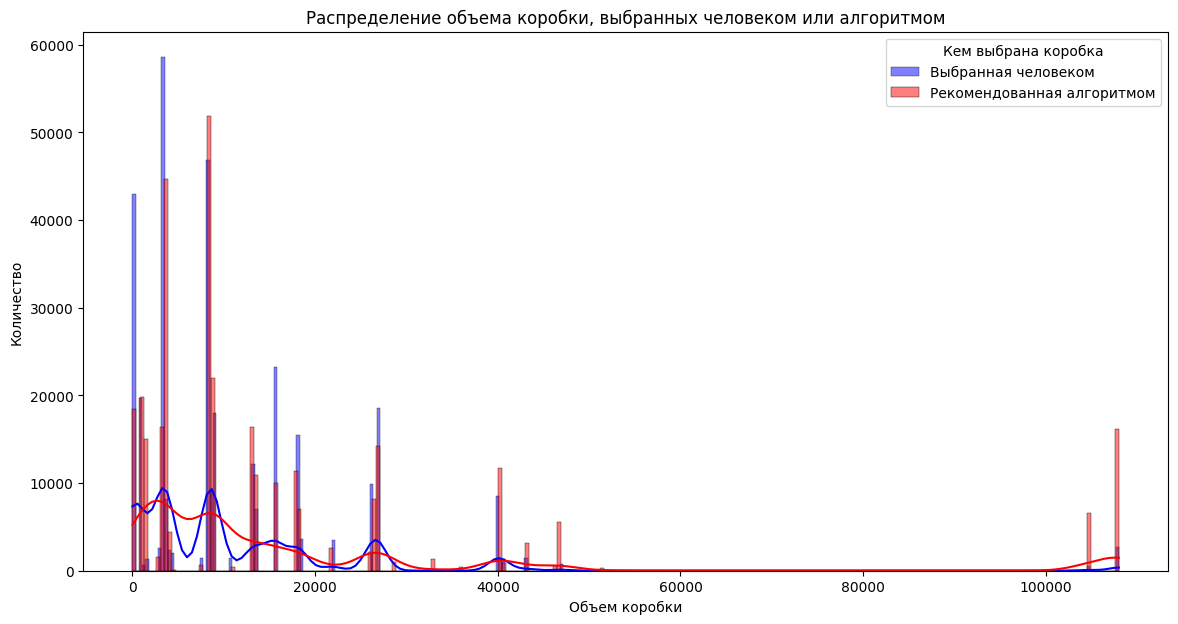

In [27]:
# Построим график с разбивкой по объему коробок, выбранных человеком или алгоритмом:
plt.figure(figsize=(14, 7))

sns.histplot(data=data['sel_calc_cube'], color='blue', label='Выбранная человеком', kde=True)
sns.histplot(data=data['rec_calc_cube'], color='red', label='Рекомендованная алгоритмом', kde=True)

plt.xlabel('Объем коробки')
plt.ylabel('Количество')
plt.title('Распределение объема коробки, выбранных человеком или алгоритмом')
plt.legend(title='Кем выбрана коробка')

Вывод: видно, что есть выбросы по объему коробок, особенно, что рекомендовано алгоритмом. В целом алгоритм выбирает больший объем, чем человек.

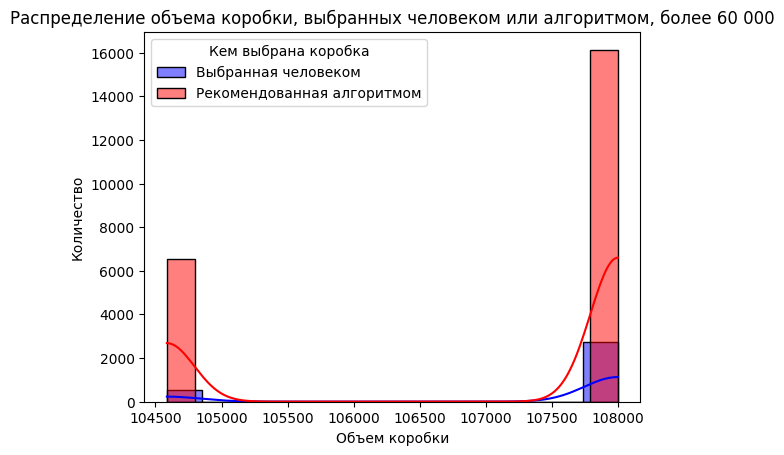

In [28]:
# Выведем выбросы по объемам коробки
sns.histplot(data=data[data['sel_calc_cube'] > 60000]['sel_calc_cube'], color='blue', label='Выбранная человеком', kde=True)
sns.histplot(data=data[data['rec_calc_cube'] > 60000]['rec_calc_cube'], color='red', label='Рекомендованная алгоритмом', kde=True)

plt.xlabel('Объем коробки')
plt.ylabel('Количество')
plt.title('Распределение объема коробки, выбранных человеком или алгоритмом, более 60 000')
plt.legend(title='Кем выбрана коробка')

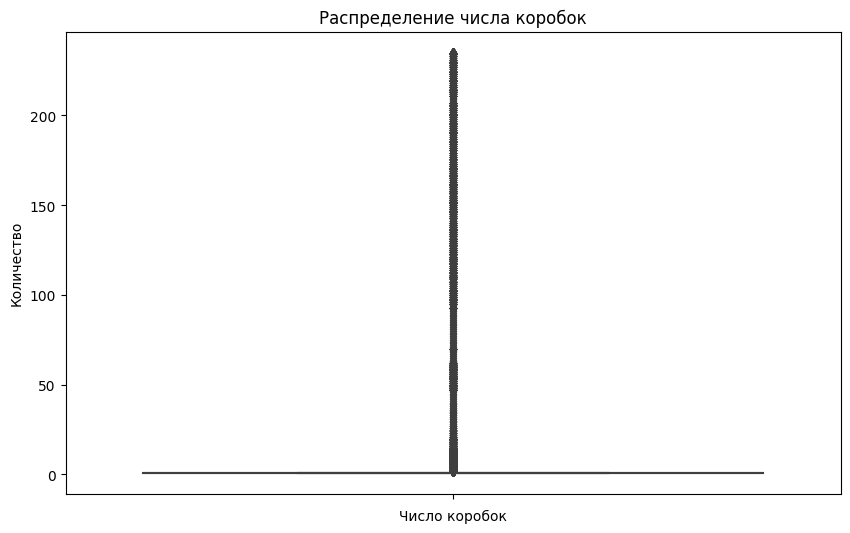

In [29]:
# Выведем данные по числу коробок больше 3 в заказе и объем больше 60000
plt.figure(figsize=(10,6))
sns.boxplot(data=data, y='box_num')
plt.title('Распределение числа коробок')
plt.xlabel('Число коробок')
plt.ylabel('Количество')
plt.show()

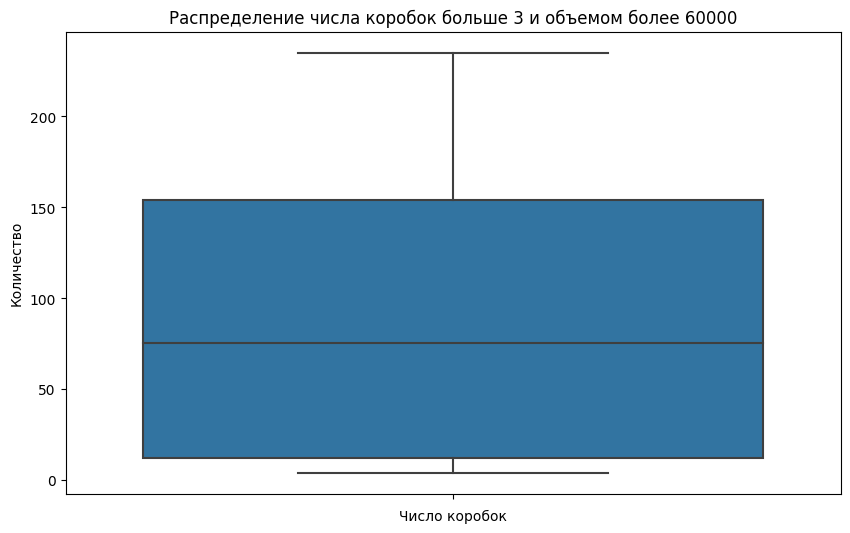

In [30]:
# Выведем данные по числу коробок больше 3 в заказе и объем больше 60000
data_1 = data[(data['rec_calc_cube'] > 60000) & (data['box_num'] > 3)]
plt.figure(figsize=(10,6))
sns.boxplot(data=data_1, y='box_num')
plt.title('Распределение числа коробок больше 3 и объемом более 60000')
plt.xlabel('Число коробок')
plt.ylabel('Количество')
plt.show()

Вывод: Есть большое число заказов, где объем больше 60000, среднее значение коробок 75. Скорее всего данные выбросы можно будет удалить, чтобы не использовать в модели.

Проверим число коробок:

In [31]:
# Выведем уникальные значения box_num
np.sort(data['box_num'].unique())

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 18

Вывод: есть заказы аж с 235 коробками.

Сгруппируем данные для анализа:

In [32]:
# Сгруппируем data по 'sku' и аггрегируем данные
data_grouped = data.groupby('orderkey').agg({
    'sku': 'count',
    'pack_volume': list,
    'goods_wght': list,
    'box_num': 'max',
    'sel_calc_cube': list
}).reset_index()

data_grouped[data_grouped['box_num'] > 1].head(20)

,orderkey,sku,pack_volume,goods_wght,box_num,sel_calc_cube
22,000c7d0bdd236c4978d9f42f6a28a80a,1,[540],[0.24],2,[3449]
43,0016a6753131f5f0b3a9412fd8afa67a,2,"[9520, 672]","[4.0, 0.09]",2,"[0, 3449]"
45,0016f76147bdc56e211b1cb7531c5619,2,"[1920, 17576]","[0.204, 9.93]",2,"[8436, 0]"
48,00196d400f060106cafee15e5b0bf378,6,"[90, 90, 2804, 15718, 1260, 1260]","[0.1, 0.11, 1.812, 6.066, 1.089, 1.089]",2,"[13125, 13125, 13125, 0, 13125, 13125]"
52,001b33d6abaa3d03e75135830761dbb0,2,"[666000, 666000]","[63.0, 63.0]",2,"[0, 0]"
83,00236e176405ce085a6f7200e148dd7e,3,"[7400, 7400, 6120]","[1.535, 1.535, 3.026]",2,"[15579, 15579, 8436]"
100,00281dc23e0425e8809609c3aebacf73,6,"[1400, 1051, 1354, 6318, 7296, 1160]","[0.55, 1.114, 0.859, 5.0, 5.41, 0.75]",3,"[15579, 15579, 15579, 15579, 15579, 15579]"
116,002ea23b9ee98d616a13bc2a8f0a1e1d,1,[10898],[1.401],2,[3449]
143,004192c5d96941568cba1c9edaea7a34,2,"[18600, 18600]","[0.36, 0.36]",2,"[26277, 26277]"
177,004b2f2044d02b3c752e94da27708e9b,6,"[46436, 18900, 52800, 25250, 52800, 46436]","[32.0, 30.77, 32.0, 30.77, 32.0, 32.0]",6,"[0, 0, 0, 0, 0, 0]"


Проанализируем данные по числу sku в заказе:

In [33]:
# Рассчитаем долю заказов по числу sku
total_count = len(data_grouped)

# Получим уникальные значения SKU
skus = data_grouped['sku'].unique()

# Создадим списко SKU (как долю)
shares = [round(len(data_grouped[data_grouped['sku'] == sku]) / total_count * 100, 2) for sku in skus]

# Создадим DataFrame
table = pd.DataFrame({'sku_cnt': skus, 'share': shares}).sort_values(by='share', ascending=False).reset_index(drop=True)

# Выведем первые 10 значений
print(table.head(10))

   sku_cnt  share
0        1  65.02
1        2  16.72
2        3   6.47
3        4   4.02
4        5   2.39
5        6   1.56
6        7   0.81
7        8   0.62
8       10   0.57
9        9   0.38


In [34]:
print(f"Доля товаров с 4мя и более sku: {table[table['sku_cnt'] > 3]['share'].sum():.2f}%")

Доля товаров с 4мя и более sku: 11.78%


Вывод:
- Заказы с числом товаров 1 составляют 65%, с 2мя товарами - 16%, с 3мя товарами - 6%, более 4х товаров число таких заказов 12%.
- Предлагается сделать три ML модели для предсказания упаковок: 1я модель для товаров с одним sku, 2я модель для товаров с двумя sku, 3я модель для заказов с 3мя и более sku.

Проанализируем данные по числу коробок в заказе:

In [35]:
# Рассчитаем долю заказов по числу коробок
total_count = len(data_grouped)

# Получим уникальные значения коробок
boxes = data_grouped['box_num'].unique()

# Создадим список коробок (как долю)
shares = [round(len(data_grouped[data_grouped['box_num'] == box]) / total_count * 100, 2) for box in boxes]

# Создадим DataFrame
table = pd.DataFrame({'box_cnt': boxes, 'share': shares}).sort_values(by='share', ascending=False).reset_index(drop=True)

# Выведем первые 10 значений
print(table.head(10))

   box_cnt  share
0        1  94.92
1        2   3.61
2        3   0.85
3        4   0.29
4        5   0.14
5        6   0.06
6        7   0.03
7        9   0.02
8        8   0.02
9       12   0.02


In [36]:
print(f"Доля товаров с 4мя и более sku: {table[table['box_cnt'] > 2]['share'].sum():.2f}%")

Доля товаров с 4мя и более sku: 1.48%


Вывод:
- Заказы с числом коробок 1 составляют 95%, с 2мя товарами - 3,6%, с 3мя и более коробок - 1,48%.
- У команды дизайнеров и фронтенд была идея заменить всю массы коробок на три вида, которые адаптируются по размер товаров. Если 95% заказов были с одной коробкой, то такая идея очень хорошая, тк упростит хранение упаковок, а также саму упаковку товара.

Проверим объем товаров:

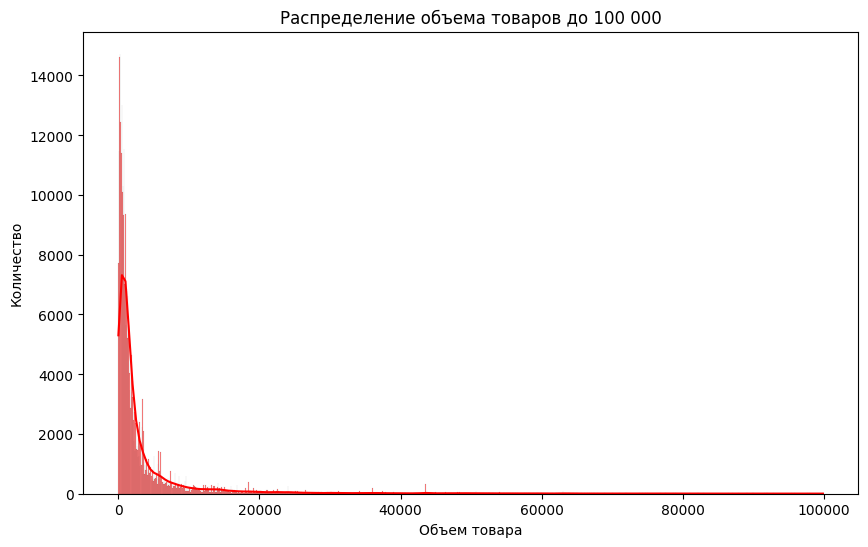

In [37]:
# Проверим объем товаров объемом до 100 000
plt.figure(figsize=(10,6))
sns.histplot(data=data[data['pack_volume'] < 100000]['pack_volume'], color='red', kde=True)
plt.title('Распределение объема товаров до 100 000')
plt.xlabel('Объем товара')
plt.ylabel('Количество')
plt.show()

**Вывод:** Большинство заказов с небольшим объемом товара до 5 000.

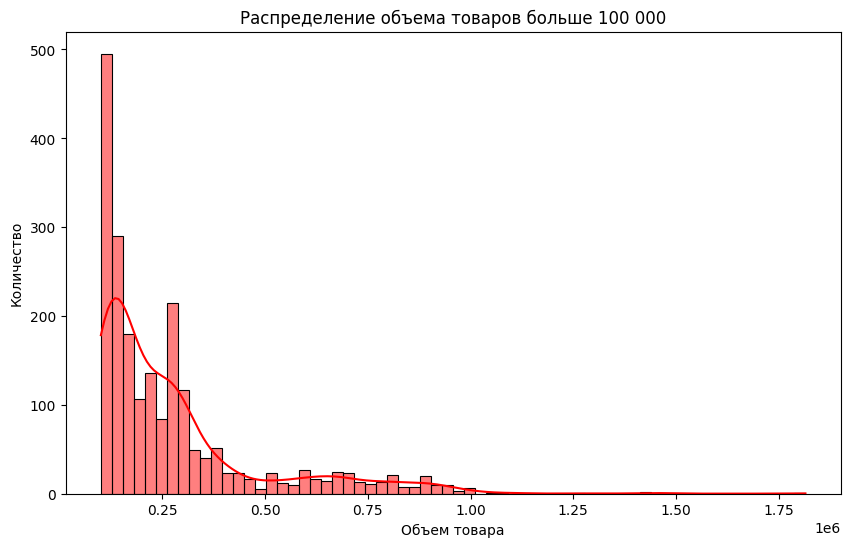

In [38]:
# Проверим объем товаров больше 100 000
plt.figure(figsize=(10,6))
sns.histplot(data=data[data['pack_volume'] > 100000]['pack_volume'], color='red', kde=True)
plt.title('Распределение объема товаров больше 100 000')
plt.xlabel('Объем товара')
plt.ylabel('Количество')
plt.show()

In [39]:
# Выведем тип упаковок для товаров объемом 100 000
data[(data['pack_volume'] > 100000) & (data['sel_calc_cube'] != 0)]['selected_cartontype'].unique()

array(['MYD', 'YMG', 'MYB', 'MYF', 'YMC', 'MYC', 'MYA'], dtype=object)

**Вывод:** для товаров объемом больше 100 000 в основном это пакетики, но и есть коробки YMG и YMC.

Сравним распределение объемов коробок и товаров:

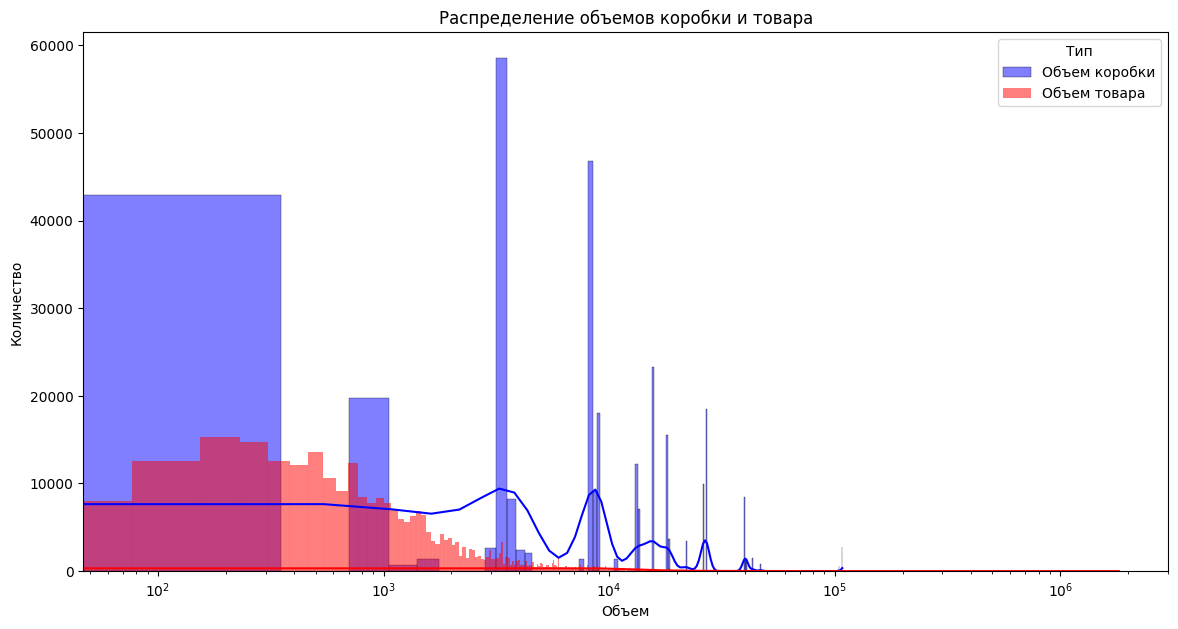

In [40]:
# Построим график с разбивкой по объему коробок и товара:
plt.figure(figsize=(14, 7))

sns.histplot(data=data['sel_calc_cube'], color='blue', label='Объем коробки', kde=True)
sns.histplot(data=data['pack_volume'], color='red', label='Объем товара', kde=True)

plt.xlabel('Объем')
plt.ylabel('Количество')
plt.title('Распределение объемов коробки и товара')
plt.legend(title='Тип')

plt.xscale('log')  # Установим x-axis как логарифмическую шкалу

plt.show()

Вывод: Гдето объем коробки совпадает с товаром, а гдето он сильно больше.

Проверим вес товаров:

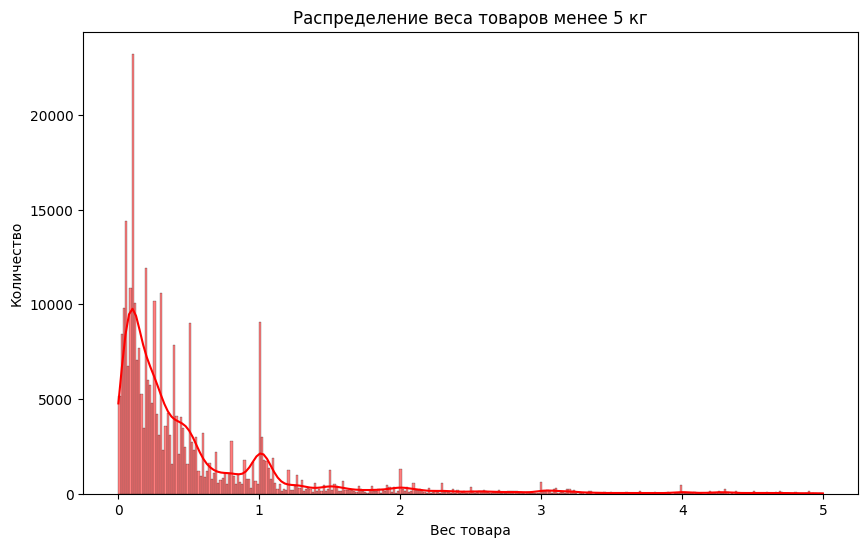

In [41]:
# Проверим еще вес товаров на выбросы, выведем товары менее 5 кг
plt.figure(figsize=(10,6))
sns.histplot(data=data[data['goods_wght'] < 5]['goods_wght'], color='red', kde=True)
plt.title('Распределение веса товаров менее 5 кг')
plt.xlabel('Вес товара')
plt.ylabel('Количество')
plt.show()

**Вывод:** легких товаров большинство.

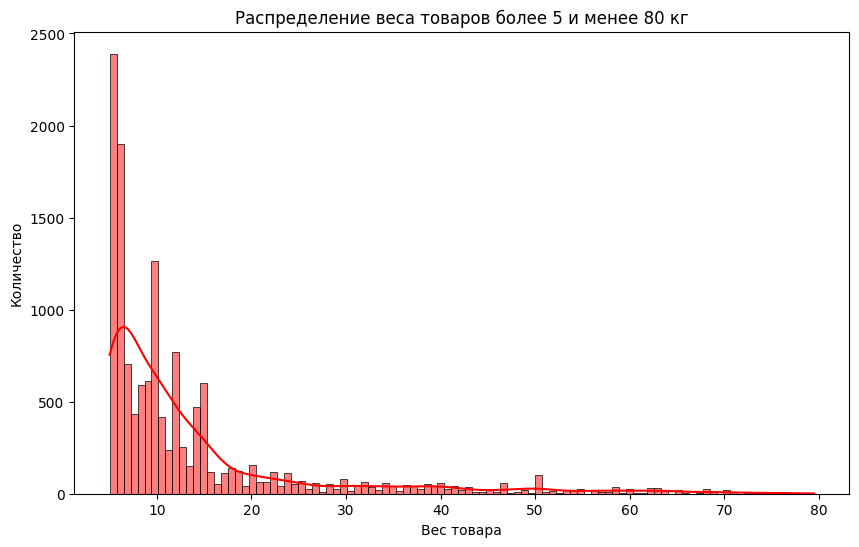

In [42]:
# Выведем товары более 5 и менее 80 кг
plt.figure(figsize=(10,6))
sns.histplot(data=data[(data['goods_wght'] > 5) & (data['goods_wght'] < 80)]['goods_wght'], color='red', kde=True)
plt.title('Распределение веса товаров более 5 и менее 80 кг')
plt.xlabel('Вес товара')
plt.ylabel('Количество')
plt.show()

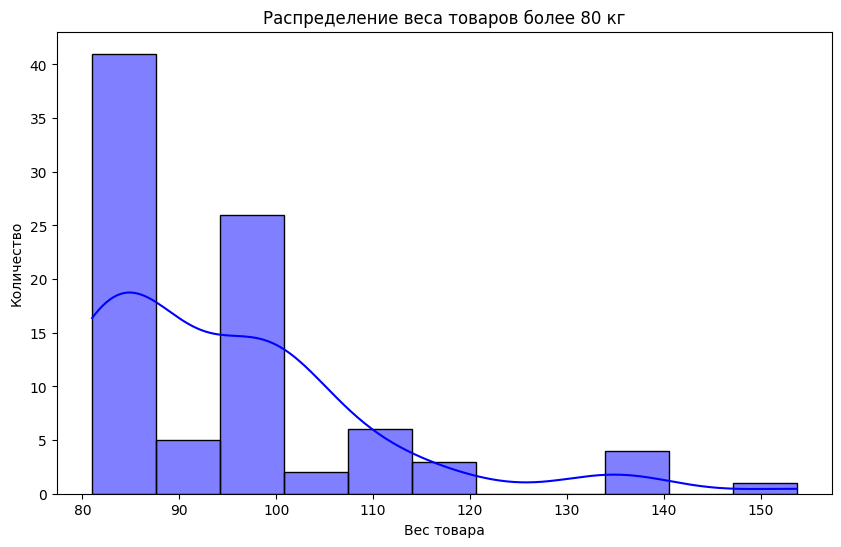

In [43]:
# Проверим тяжелые товары
plt.figure(figsize=(10,6))
sns.histplot(data=data[data['goods_wght'] > 80]['goods_wght'], color='blue', kde=True)
plt.title('Распределение веса товаров более 80 кг')
plt.xlabel('Вес товара')
plt.ylabel('Количество')
plt.show()

Вывод: не понятно, что это за товар тяжелее 80 кг, нужно присоединить карготипы к датасету.

In [44]:
# Проверим данные, где вес больше 20 и объем выбранной коробки не 0
data[(data['goods_wght'] > 20) & (data['sel_calc_cube'] != 0)]

,whs,orderkey,selected_cartontype,box_num,recommended_cartontype,selected_carton,sel_calc_cube,recommended_carton,pack_volume,rec_calc_cube,goods_wght,sku,who,trackingid


Вывод: таких данных нет.

In [45]:
# Выведем тип выбранной упаковки при весе более 20
data[(data['goods_wght'] > 20)]['selected_cartontype'].unique()

array(['NONPACK', 'STRETCH'], dtype=object)

**Вывод:** Можно все, что больше 20 кг не передавать в модель, тк либо нет упаковки, либо пленка. Как вариант для модели удалить sku, упакованные в NONPACK или STRETCH, и обрабатывать такие sku до передачи модели.

### Объединим датасеты и исследуем полученные данные

Соберем информацию о товарах в единое целое.

In [46]:
# Сначало объединим sku и sku_cargotypes по столбцу 'sku' (left join)
merged_sku = sku.merge(sku_cargotypes, on='sku', how='left')

# Затем результат объединим с cargotype_info по столбцу 'cargotype'  (left join)
merged_sku = merged_sku.merge(cargotype_info, on='cargotype', how='left').rename(columns={'cargotype': 'cargo_type'})

merged_sku.head()

,sku,good_length,good_width,good_height,cargo_type,description
0,8ba57dcdba9a58b0c4edd180bef6afc9,11.00,31.00,28.00,200.00,техника и электроника
1,8ba57dcdba9a58b0c4edd180bef6afc9,11.00,31.00,28.00,290.00,Склад МГТ (малогабаритный товар)
2,d9af6ce6f9e303f4b1a8cb47cde21975,29.00,14.00,40.00,290.00,Склад МГТ (малогабаритный товар)
3,d9af6ce6f9e303f4b1a8cb47cde21975,29.00,14.00,40.00,360.00,упаковка в пленку
4,d9af6ce6f9e303f4b1a8cb47cde21975,29.00,14.00,40.00,490.00,средства личной гигиены


In [47]:
# Выведем данные поп количеству description
merged_sku['description'].value_counts().head(50)

Склад МГТ (малогабаритный товар)                    5096604
пачкается                                           1531872
техника и электроника                                997228
хрупкое                                              750011
впитывает запах                                      743106
одежда, обувь, аксессуары                            674183
товары для красоты                                   616669
опасный Авиа                                         602280
косметика и парфюмерия                               534116
Склад СГТ (среднегабаритный товар)                   515821
цена низкая                                          503393
средства личной гигиены                              480597
химикаты                                             473196
мнется                                               422356
аптека                                               404050
жидкость                                             401604
Склад КГТ (крупногабаритный товар)      

Вывод:
- можно выделить пачкается, хрупкое, впитывает запах, мнется, интим товар, пахучий, пачкает,
- в особенности - не требует упаковки и упаковка в пленку. Есть такие упаковки NONPACK и STRETCH. Такой карготип можно совместить в алгоритме с упаковкой и не использовать модель ML.

Соберем информацию о коробках в один датасет:

In [48]:
# Объединим carton и carton_price по carton_type
merged_carton = carton.merge(carton_price, on='carton_type', how='left').sort_values(by='carton_type').reset_index(drop=True)

merged_carton.head(30)

,carton_type,box_length,box_width,box_height,box_price
0,KSD,0.00,0.00,0.00,NaN
1,MYA,15.00,20.00,3.33,1.11
2,MYB,22.00,32.00,4.90,2.30
3,MYC,30.00,38.00,7.40,3.62
4,MYD,38.00,50.00,8.20,6.92
5,MYE,43.00,63.00,9.70,8.06
6,MYF,20.00,15.00,5.00,4.08
7,NONPACK,0.00,0.00,0.00,NaN
8,STRETCH,0.00,0.00,0.00,NaN
9,YMA,24.70,15.00,10.00,4.39


Вывод:
- цены есть не для всех коробок - из 20 коробок цены есть на 9 коробок,
- есть неизвестная упаковка KSD, которая в заказах отсутствует,
- MYA, MYB, MYC, MYD, MYE, MYF - по словам заказчика это пленка на товары,
- С буквой Y - картонные коробки. Их 20 штук. Наши дизайнеры предложили их заменить на 3 типа коробок, которые могут трансформироваться и заменят все необходимын размеры.

Проанализируем размеры и объемы товаров и коробок, объединив датасеты и сгруппировав данные:

In [52]:
# Объединим датасеты с данными
merged_df = df.merge(merged_sku, on='sku', how='left')
merged_df = merged_df.merge(merged_carton, left_on='selected_cartontype', right_on='carton_type', how='left')
merged_df.drop('carton_type', axis=1, inplace=True)

# добавим периметр в данные
merged_df['good_perimeter'] = merged_df['good_length'] + merged_df['good_width'] + merged_df['good_height']
merged_df['box_perimeter'] = merged_df['box_length'] + merged_df['box_width'] + merged_df['box_height']

merged_df.head()

,orderkey,selected_cartontype,box_num,box_volume,good_volume,goods_wght,sku,good_length,good_width,good_height,cargo_type,description,box_length,box_width,box_height,box_price,good_perimeter,box_perimeter
0,d48f3211c1ffccdc374f23139a9ab668,NONPACK,1,0,2046,0.10,af49bf330e2cf16e44f0be1bdfe337bd,11.00,6.00,31.00,290.00,Склад МГТ (малогабаритный товар),0.00,0.00,0.00,NaN,48.00,0.00
1,d48f3211c1ffccdc374f23139a9ab668,NONPACK,1,0,2046,0.10,af49bf330e2cf16e44f0be1bdfe337bd,11.00,6.00,31.00,600.00,"одежда, обувь, аксессуары",0.00,0.00,0.00,NaN,48.00,0.00
2,d48f3211c1ffccdc374f23139a9ab668,NONPACK,1,0,2046,0.10,af49bf330e2cf16e44f0be1bdfe337bd,11.00,6.00,31.00,610.00,обувь взрослая,0.00,0.00,0.00,NaN,48.00,0.00
3,d48f3211c1ffccdc374f23139a9ab668,NONPACK,1,0,2046,0.10,af49bf330e2cf16e44f0be1bdfe337bd,11.00,6.00,31.00,950.00,пачкается,0.00,0.00,0.00,NaN,48.00,0.00
4,d48f3211c1ffccdc374f23139a9ab668,NONPACK,1,0,2046,0.10,af49bf330e2cf16e44f0be1bdfe337bd,11.00,6.00,31.00,970.00,впитывает запах,0.00,0.00,0.00,NaN,48.00,0.00


In [55]:
# Сгруппируем merged_df по 'orderkey' и аггрегируем данные
data_grouped = merged_df.groupby('orderkey').agg({
    'sku': 'count',
    'box_num': 'max',
    'goods_wght': 'sum',
    'good_perimeter': 'sum',
    'box_perimeter': 'sum',
    'good_volume': 'sum',
    'box_volume': 'sum'
}).reset_index()

In [56]:
data_grouped.head()

,orderkey,sku,box_num,goods_wght,good_perimeter,box_perimeter,good_volume,box_volume
0,00004fc4755eeb7e851e52ec91130fe4,4,1,4.00,244.00,301.60,15504,33744
1,00008e765c2d85abfa9c97563afd98ef,6,1,0.81,162.00,353.40,1710,20694
2,0000c268eb1be1dd5b8c1a032f7318fc,18,1,1.62,882.00,"1,357.20",53550,151848
3,0000fc4c7acac6e89f82392b90e47a27,6,1,1.20,183.00,353.40,4248,20694
4,0001963724fa4cc12d4f025056085633,60,1,13.34,"2,040.00","5,100.00",73800,1080000


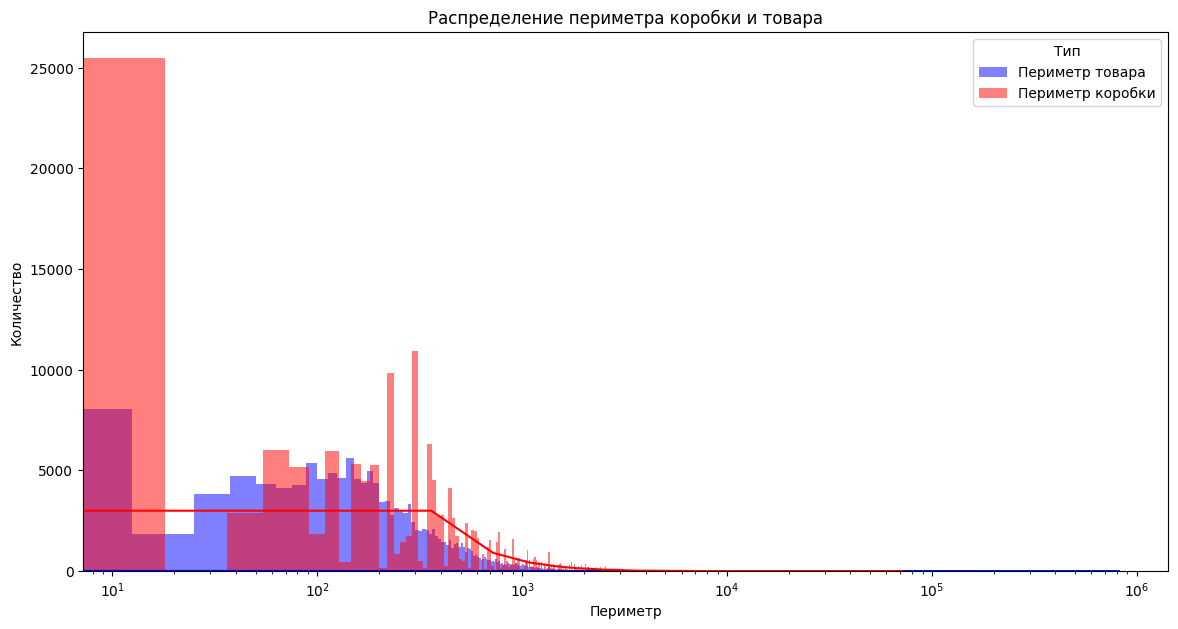

In [57]:
# Построим график с разбивкой по периметру коробок и товара:
plt.figure(figsize=(14, 7))

sns.histplot(data=data_grouped['good_perimeter'], color='blue', label='Периметр товара', kde=True)
sns.histplot(data=data_grouped['box_perimeter'], color='red', label='Периметр коробки', kde=True)

plt.xlabel('Периметр')
plt.ylabel('Количество')
plt.title('Распределение периметра коробки и товара')
plt.legend(title='Тип')

plt.xscale('log')  # Установим x-axis как логарифмическую шкалу

plt.show()

Вывод: местами выбранный размер коробки превышает предоставленный товар. Особенно это заметно при небольшом товаре.

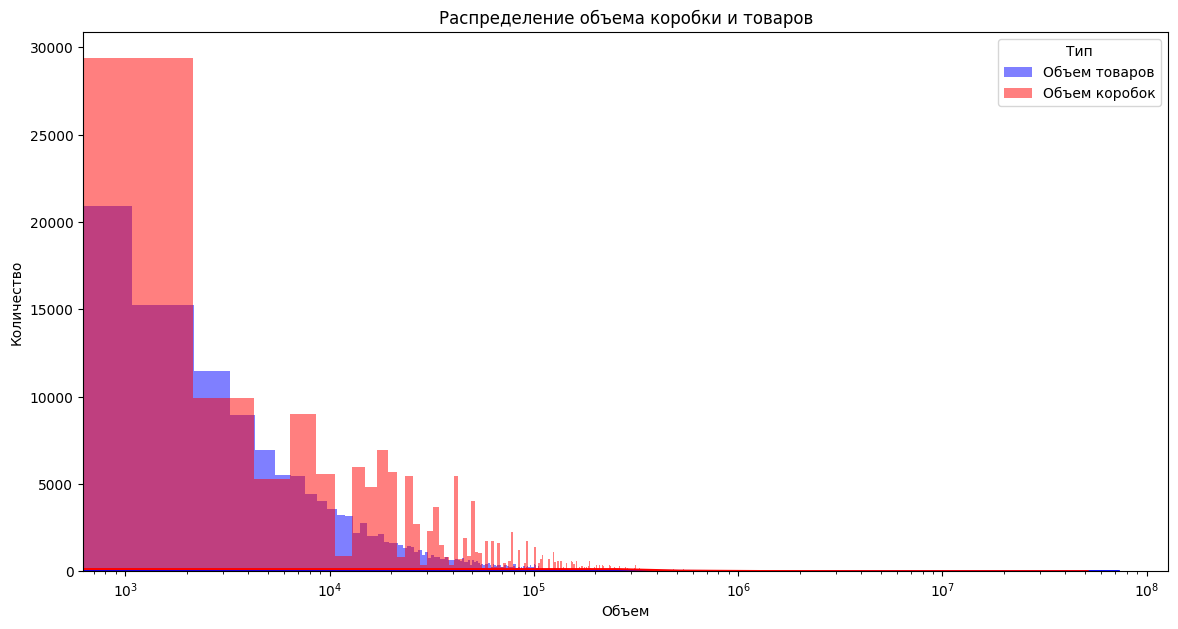

In [58]:
# Построим график с разбивкой по объему коробок и товара:
plt.figure(figsize=(14, 7))

sns.histplot(data=data_grouped['good_volume'], color='blue', label='Объем товаров', kde=True)
sns.histplot(data=data_grouped['box_volume'], color='red', label='Объем коробок', kde=True)

plt.xlabel('Объем')
plt.ylabel('Количество')
plt.title('Распределение объема коробки и товаров')
plt.legend(title='Тип')

plt.xscale('log')  # Установим x-axis как логарифмическую шкалу

plt.show()

Вывод: здесь также выбранный объем коробки превышает предоставленный товар небольшого размера.

Построим матрицу корреляции по числовым признакам:

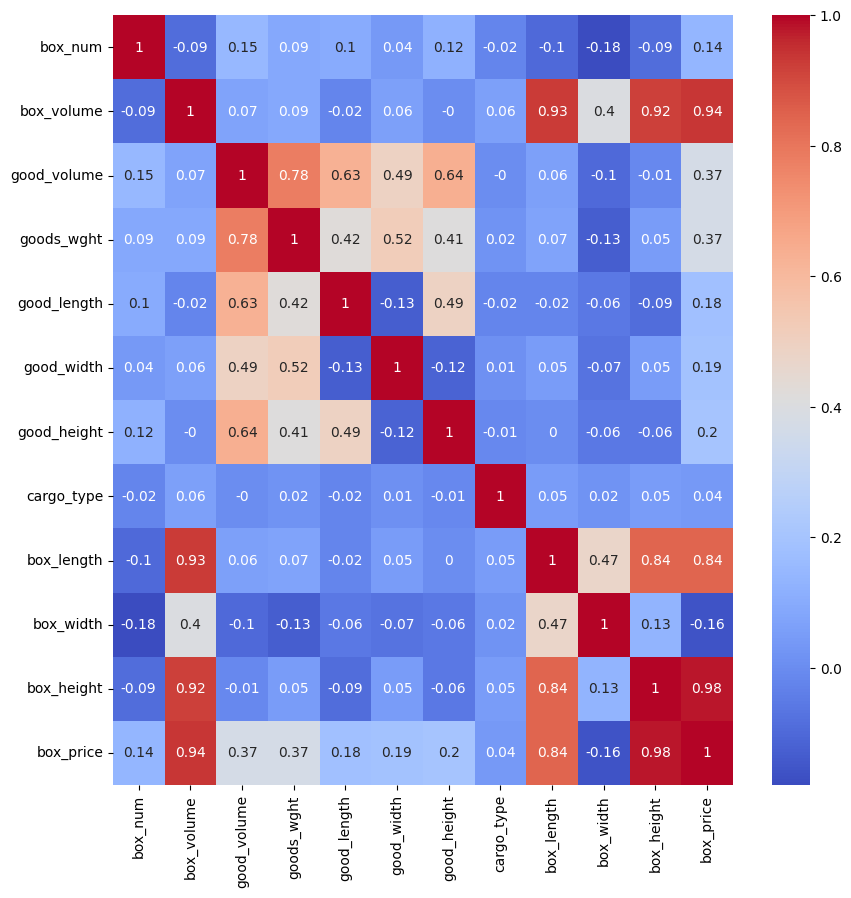

In [51]:
# Выведем матрицу корреляции
plt.figure(figsize = (10,10))
sns.heatmap(merged_df.corr(method= 'spearman').round(2), annot =True, cmap = 'coolwarm')
plt.show()

**Вывод:**
- целевой признак (таргет) выбираем selected_cartontype код коробки. Данный признак связан с объемом коробки sel_calc_cube, размерами коробки и ее ценой box_price.
- Есть явная корреляция между sel_calc_cube и box_price. box_price в модели использовать не будем из-за корреляции и тк цены есть только на половину из предствленных упаковок.

### Общие выводы по итогам EDA

**По работе старого алгоритма:**

- Если принять, что выбор упаковщика был верный, то старый алгоритм ошибался в 75% случаев.

- Судя по предоставленным данным человек больше выбирал пакетики, а алгоритм предлагал коробки и побольше. Пленку и без упаковки алгоритм вообще практически не предлагал.

- Есть выбросы по объему коробок, особенно, что рекомендовано алгоритмом. В целом алгоритм выбирает больший объем, чем человек.

**Про объем упаковок:**

- Есть большое число заказов, где объем коробки больше 60000, среднее значение коробок 75. Скорее всего данные выбросы можно будет удалить, чтобы не использовать в модели.

**Число sku:**

- Заказы с числом товаров 1 составляют 65%, с 2мя товарами - 16%, с 3мя товарами - 6%, более 4х товаров число таких заказов 12%.

- Предлагается сделать три ML модели для предсказания упаковок: 1я модель для товаров с одним sku, 2я модель для товаров с двумя sku, 3я модель для заказов с 3мя и более sku.

**Число коробок в одном заказе**

- Заказы с числом коробок 1 составляют 95%, с 2мя товарами - 3,6%, с 3мя и более коробок - 1,48%.

- У команды дизайнеров и фронтенд была идея заменить всю массы коробок на три вида, которые адаптируются по размер товаров. Если 95% заказов были с одной коробкой, то такая идея очень хорошая, тк упростит хранение упаковок, а также саму упаковку товара.

**Объем товаров:**

- Большинство заказов с небольшим объемом товара до 5 000.

- Для товаров объемом больше 100 000 в основном это пакетики, но и есть коробки YMG и YMC.

- Гдето объем коробки совпадает с товаром, а гдето он сильно больше.

**Вес товаров:**

- Легких товаров до 1 кг большинство.

- Есть товары более 80 кг.

- Товары весом более 20 кг имели NONPACK или STRETCH. Можно все, что больше 20 кг не передавать в модель, тк либо нет упаковки, либо пленка. Как вариант для модели удалить sku, упакованные в NONPACK или STRETCH, и обрабатывать такие sku до передачи модели.

**Тип коробок:**

- MYA, MYB, MYC, MYD, MYE, MYF - по словам заказчика это пленка на товары. По идее их можно выбирать вручную тк это пакет под размер товара, не используя ML.

- С буквой Y - картонные коробки. Их 20 штук. Цены есть не для всех коробок - из 20 коробок цены есть на 9 коробок. Наши дизайнеры предложили их заменить на 3 типа коробок, которые могут трансформироваться и заменят все необходимын размеры.

**Соотношение размеров товара и коробок:**

- Периметр: Местами выбранный размер коробки превышает предоставленный товар. Особенно это заметно при небольшом товаре.

- Объем: выбранный объем коробки превышает предоставленный товар небольшого размера.

**Карготипы:**

- Самые популярные в упаковках: NONPACK без упаковки на третьем месте, пленка STRETCH на шестом месте. В карготипах есть указания "не упаковывать" и "в пленку". Такое можно вписать в ручной алгоритм, не используя ML.

## Рекомендации по реализации обучения модели ML

**Рекомендации для DS при подготовке данных для ML модели:**

1. До обучения модели предлагается удалить выбросы из данных, чтобы не учитывать их в модели:
  - все товары, тяжелее 20 кг,
  - все товары, объем которых превышает самую большую коробку YMC в 100 000,
  - заказы, где объем коробок превышает 50 шт.

2. Для определения признаков, которые мы подаем на вход при обучении модели предлагается учесть, что мы получаем от бэкенд - число sku, длина, ширина, высота товара, вес товара, карготипы.

  Учитывая входные данные, предлагается использовать число sku, вес товара и карготипы как есть, а также рассчитать дополнительно две метрики - объем всех товаров в заказе, перемножив длину, ширину, высоту товара, и периметр всех товаров, сложив размеры товаров. Также рассчитаем объем и периметр коробок.

  - counts_sku - число sku, тк это важно для общего объема товара для упаковки,
  - goods_wght - вес товара крайне важен, как упаковывать,
  - периметр и объем товаров - размерные метрики, которые необходимо рассчитать,
  - периметр и объем коробки,
  - cargo_types - имеют важные данные в части описания товара.

3. Таргетом предлагается сделать selected_cartontype - код упаковки, которая была выбрана пользователем в предоставленных данных.

**Рекомендации для бэкенд:**

  - обрабатывать товары с карготипами 340 без упаковки и 360 стретчпленка без использования ML модели,
  - обрабатывать крупногабаритные и тяжелые товары без использования ML модели, они часто идут в своей упаковке и дополнительную не требуют.

## MLOps: материалы для бэкенд

Фукнция для обработки входящего JSON и применения 3х моделей сохраненных в формате pickle:

```
# Фукнция model.py
import pickle
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

def predict(order):

    items = order['items']
    # Count the number of unique SKUs in the order
    num_skus = len(items)

    # Create a mapping from JSON field names to model field names
    field_mapping = {
        'size1': 'a',
        'size2': 'b',
        'size3': 'c',
        'weight': 'goods_wght'
    }

    # Assume these are the columns the model was trained on, in the correct order
    model_columns = ['counts_sku', 'goods_wght', 'volume_sku', 'P', 'cargo_0', 'cargo_1', 'cargo_2', 'cargo_3',
                     'cargo_4', 'cargo_5', 'cargo_6', 'cargo_7', 'cargo_8', 'cargo_9', 'cargo_10']

    df = pd.DataFrame(items)  # Create a DataFrame with a list of dictionaries

    # Convert strings to floats
    df['size1'] = df['size1'].astype(float)
    df['size2'] = df['size2'].astype(float)
    df['size3'] = df['size3'].astype(float)
    df['weight'] = df['weight'].astype(float)

    # Convert 'type' to integer
    df['type'] = df['type'].apply(lambda x: [float(i) for i in x])

    # Apply transformations and feature engineering as done during model training
    df['volume_sku'] = df['size1'] * df['size2'] * df['size3'] * df['count']
    df['P'] = (df['size1'] + df['size2'] + df['size3']) * df['count']

    # Rename columns in the DataFrame
    for json_field, model_field in field_mapping.items():
        df.rename(columns={json_field: model_field}, inplace=True)

    # Create a dataframe that holds all the model features
    model_df = pd.DataFrame(columns=model_columns)
    model_df.loc[0, 'counts_sku'] = num_skus
    model_df.loc[0, 'goods_wght'] = df['goods_wght'].sum()
    model_df.loc[0, 'volume_sku'] = df['volume_sku'].sum()
    model_df.loc[0, 'P'] = df['P'].sum()

    # Initialize all cargo columns with 0
    model_df.iloc[0, 4:] = 0

    # Fill the cargo columns based on the cargotypes in the data
    cargo_types = [item for sublist in df['type'].to_list() for item in sublist]  # Flatten the list
    unique_cargo_types = list(set(cargo_types)) # Get unique values

    for i in range(len(unique_cargo_types)):
        model_df.iloc[0, i + 4] = unique_cargo_types[i]  # Fill the cargo columns

    # Load the model
    with open(f'model{min(num_skus, 3)}.pkl', 'rb') as file:
        model = pickle.load(file)

    y_pred = model.predict(model_df)

    # Load LabelEncoder from a file
    with open('label_encoder.pkl', 'rb') as f:
        le = pickle.load(f)

    if isinstance(y_pred, np.ndarray):
        y_pred = y_pred.tolist()  # convert numpy array to list if it's an array

    y_pred = le.inverse_transform(y_pred)

    # return the first element if it's a single element list, else return the whole list
    return y_pred[0] if len(y_pred) == 1 else y_pred
```

Функция для запуска вебсервиса:
```
# Функция app.py
from fastapi import FastAPI, Request
from fastapi import HTTPException
import uvicorn
import argparse
from model import predict
from pydantic import BaseModel
from typing import List

class Item(BaseModel):
    sku: str
    count: int
    size1: str
    size2: str
    size3: str
    weight: str
    type: List[str]

class Order(BaseModel):
    orderId: str
    items: List[Item]

app = FastAPI()


@app.get("/health")
def health():
    return {"status": "ok"}


@app.post("/pack")
def get_prediction(request: Order):
    try:
        items = [el.dict() for el in request.items]
        y = predict({'items': items})
        return {"orderId": request.orderId, "package": y, "status": "ok"}


    except Exception as e:

        print(f"Exception: {e}")

        raise HTTPException(status_code=400, detail={"orderId": request.orderId, "status": "fail"})


if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument("--port", default=8001, type=int, dest="port")
    parser.add_argument("--host", default="0.0.0.0", type=str, dest="host")
    parser.add_argument("--debug", action="store_true", dest="debug")
    args = vars(parser.parse_args())

    if args['debug']:
        uvicorn.run(app, host=args['host'], port=args['port'], log_level="debug")
    else:
        uvicorn.run(app, host=args['host'], port=args['port'])
```

Requirement.txt
```
fastapi==0.96.0
uvicorn==0.22
pandas==1.5.3
scikit-learn==1.2.2
xgboost==1.7.5
catboost==1.2
```

test.py для проверки работы докера
```
import requests
import json

data = {"orderId": "unique_order_id",
 "items": [
    {"sku": "unique_sku_1", "count": 1, "size1": "5.1", "size2": "2.2", "size3": "5.3",
     "weight": "7.34", "type": ["2"]},
    {"sku": "unique_sku_2", "count": 3, "size1": "4", "size2": "5.23", "size3": "6.2",
     "weight": "7.45", "type": ["8", "9", "10"]},
    {"sku": "unique_sku_3", "count": 2, "size1": "11", "size2": "12.5", "size3": "13.3",
     "weight": "14.2", "type": ["15", "16"]}
   ]
}

r = requests.post("http://localhost:8001/pack", json=data)

try:
    print(r.json())
except json.JSONDecodeError:
    print("Invalid or empty JSON response.")
```

**Docker file:**

```
FROM python:3.9

COPY ./src /app

WORKDIR /app

RUN pip install -r requirements.txt

CMD ["python", "app.py"]
```